In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
#from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\AppData\Roaming\Python\Python37\site-pack

In [3]:
os.chdir('Sign-Language-Digits-Dataset')#change directory
if os.path.isdir('train/0/') is False: 
    #is there is no such directory as train/0 then make directory
    #make three directories 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        """Syntax: shutil.move(source, destination)
        
           source: A string representing the path of the source file.
           destination: A string representing the path of the destination directory.
           
           f' is the string formatting for the values
           eg:- f'{i}''  ---> '3' directory"""
        
        shutil.move(f'{i}', 'train')#move every directory(0, 1, ...) in the current directory to the train directory created
        os.mkdir(f'valid/{i}') # mean while create 10 directories inside valid directory
        os.mkdir(f'test/{i}') # mean while create 10 directories inside test directory

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)#get 30 data from train/i directories to variable
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')#send them into different directories in the valid  directory

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)#get 5 data from train/i directories to variable
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')#send them into different directories in the test  directory
os.chdir('../..')#go back

In [4]:
#defining paths for the accesses
train_path = '...'
valid_path = '...'
test_path = '...'

In [5]:
#here preprocessing is the mobilnet and batch size is 10 and test set no shuffle is done as have see the original raw data

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
    
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
    
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [23]:
#loading the original mobile structure
mobile = tf.keras.applications.mobilenet.MobileNet()

In [24]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [25]:
"""here from the summary it can be shown that last three layers are connected to output 1000 different classes so 
   we have to remove them and from the dropout layer only 1000 are taken after regularization and to get dropout reshape is 
   done previously so to get 10 different classes have to remove those layers"""
x = mobile.layers[-6].output
"""then we add 10 class softmax layer as the last layer"""
#this is how we join layers in the functional model -------------------------
output = Dense(units=10, activation='softmax')(x)
#in keras functional model we have to define the inputs and outputs for the functional model
#here we use original inputs from the model 
#output for the functional model is the model that we created
model = Model(inputs=mobile.input, outputs=output)

In [26]:
#now freeze the layers we want
for layer in model.layers[:-23]:
    layer.trainable = False

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [28]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
172/172 - 332s - loss: 0.8011 - acc: 0.7529 - val_loss: 1.3687 - val_acc: 0.5333
Epoch 2/30
172/172 - 329s - loss: 0.1920 - acc: 0.9620 - val_loss: 0.8725 - val_acc: 0.7233
Epoch 3/30
172/172 - 316s - loss: 0.0835 - acc: 0.9901 - val_loss: 0.7746 - val_acc: 0.7200
Epoch 4/30
172/172 - 317s - loss: 0.0540 - acc: 0.9971 - val_loss: 0.6890 - val_acc: 0.7600
Epoch 5/30
172/172 - 318s - loss: 0.0454 - acc: 0.9947 - val_loss: 0.5229 - val_acc: 0.8600
Epoch 6/30
172/172 - 310s - loss: 0.0468 - acc: 0.9959 - val_loss: 0.5283 - val_acc: 0.8400
Epoch 7/30
172/172 - 303s - loss: 0.0412 - acc: 0.9971 - val_loss: 0.5814 - val_acc: 0.7967
Epoch 8/30
172/172 - 303s - loss: 0.0185 - acc: 0.9988 - val_loss: 0.4216 - val_acc: 0.8867
Epoch 9/30
172/172 - 302s - loss: 0.0152 - acc: 0.9982 - val_loss: 0.4727 - val_acc: 0.8433
Epoch 10/30
172/172 - 359s - loss: 0.0089 - acc: 1.0000 - val_loss: 0.4904 - val_acc: 0.8367
Epoch 11/30
172/172 - 364s - loss: 0.0087 - acc: 0.9994 - val_loss: 0.3800 - va

In [ ]:
#checks first to see if the file exits already
#if not the model is saved to disk
from os import path
if os.path.isfile('... .h5') is False:
    model.save('... .h5')

In [6]:
#lets import the saved data back
from tensorflow.keras.models import load_model
new_model = load_model('... .h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [8]:
test_labels = test_batches.classes

In [9]:
predictions = new_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [10]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 0 0]
 [0 0 1 4 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 2 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 4 1 0]
 [0 1 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 5]]


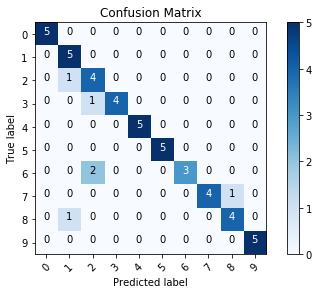

In [13]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')